In [1]:
import sys
import os
sys.path.append('..')
from adjoint_esn.dynamical_systems import Lorenz63, Lorenz96
import adjoint_esn.solve_ode as solve_ode
import numpy as np
import matplotlib.pyplot as plt
from adjoint_esn.esn import ESN
from adjoint_esn.utils import preprocessing as pp

In [ ]:
# run lorenz63 system
my_lorenz63 = Lorenz63(beta=8/3, rho=28, sigma=10, t_lyap=0.906**(-1))

dt = 1e-2

t_transient_len = 200
t_washout_len = 2
t_train_len = 50*my_lorenz63.t_lyap
t_val_len = 15*my_lorenz63.t_lyap
t_sim_len = t_transient_len+2*t_washout_len+t_train_len+t_val_len

upsample = 2
t_sim = np.arange(0,t_sim_len,dt/upsample)
rnd = np.random.RandomState(seed = 10)
u0 = rnd.random((my_lorenz63.N_dim)) 
U_sim = solve_ode.integrate(my_lorenz63, u0, t_sim, integrator='forward_euler')

In [ ]:
# run lorenz96 system
my_lorenz96 = Lorenz96(p = 8.0, t_lyap = 1.2**(-1))

dt = 1e-2

t_transient_len = 200
t_washout_len = 2
t_train_len = 50*my_lorenz96.t_lyap
t_val_len = 15*my_lorenz96.t_lyap
t_sim_len = t_transient_len+2*t_washout_len+t_train_len+t_val_len

upsample = 2
t_sim = np.arange(0,t_sim_len,dt/upsample)
rnd = np.random.RandomState(seed = 10)
u0 = rnd.random((6)) 
U_sim = solve_ode.integrate(my_lorenz96, u0, t_sim, integrator='forward_euler')[:,2][:,None]

In [67]:
# load rijke system from data
data_path = "data/rijke_kings_beta_7_tau_0_2_long_fine.h5"
data_dict = pp.read_h5(data_path)

dt = 1e-1

t_transient_len = data_dict["t_transient"]
t_washout_len = 4
t_train_len = 512
t_val_len = 64

data_dt = data_dict["t"][1]-data_dict["t"][0]
upsample = int(np.round(dt/data_dt))

grid_upsample = 8
pres = data_dict["P"][:,1:-1:grid_upsample]
pres_single = data_dict["P"][:,5][:,None]
vel = data_dict["U"]
pres_vel = np.hstack((data_dict["P"][:,1:-1],data_dict["U"]))

U_sim = pres
t_sim = data_dict["t"]

In [68]:
# upsample
U = U_sim[::upsample,:]
t = t_sim[::upsample]

# cut the transient    
N_transient = int(np.round(t_transient_len/dt))
U = U[N_transient:,:]
t = t[N_transient:]-t[N_transient]

# separate into washout, train, val
N_washout = int(np.round(t_washout_len/dt))
N_train = int(np.round(t_train_len/dt))
N_val = int(np.round(t_val_len/dt))

U_washout_train = U[0:N_washout,:]

U_train = U[N_washout:N_washout+N_train-1,:]
Y_train = U[N_washout+1:N_washout+N_train,:]
t_train = t[N_washout+1:N_washout+N_train]

U_washout_val = U[N_washout+N_train:2*N_washout+N_train,:]
U_val = U[2*N_washout+N_train:2*N_washout+N_train+N_val-1,:]
Y_val = U[2*N_washout+N_train+1:2*N_washout+N_train+N_val,:]
t_val = t[2*N_washout+N_train+1:2*N_washout+N_train+N_val]

In [69]:
U_data = U[:N_washout+N_train]
U_mean = U_data.mean(axis = 0)
U_std = U_data.std(axis = 0)
m = U_data.min(axis=0)
M = U_data.max(axis=0)
U_norm = M-m 
scale = (U_mean, U_std)

In [70]:
input_bias = np.array([np.mean(np.abs((U_data-scale[0])/scale[1]))])
print('Input bias: ', input_bias)
dim = U_sim.shape[1]
print('System dimension: ', dim)
my_ESN = ESN(reservoir_size = 1000, dimension = dim, reservoir_connectivity = 3, 
                input_scaling = 0.8, spectral_radius = 1.0,
                leak_factor = 1.0, input_bias = input_bias, input_normalization = scale)

Input bias:  [0.80908117]
System dimension:  6
Input normalization is changed, training must be done again.
Input scaling is set to 1, set it separately if necessary.
Input weights are rescaled with the new input scaling.
Spectral radius is set to 1, set it separately if necessary.
Reservoir weights are rescaled with the new spectral radius.


In [71]:
my_ESN.train(U_washout_train, U_train, Y_train, tikhonov = 1e-1)

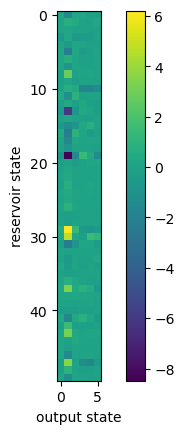

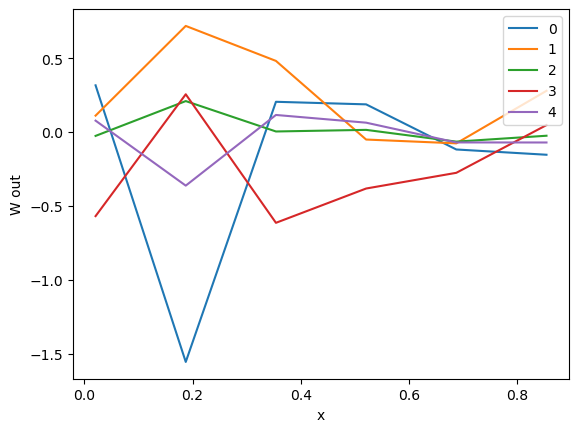

In [36]:
plt.imshow(my_ESN.output_weights[0:50,:], aspect = 1)
plt.colorbar()
plt.xlabel("output state")
plt.ylabel("reservoir state")
plt.show()

plt.plot(data_dict["x"][1:-1:grid_upsample],my_ESN.output_weights[0:5,:].T)
plt.xlabel("x")
plt.ylabel("W out")
plt.legend(range(5), loc = "upper right")
plt.show()

In [72]:
X_pred_train, Y_pred_train = my_ESN.closed_loop_with_washout(U_washout_train, N_t = N_train-1)
Y_pred_train = Y_pred_train[1:,:]

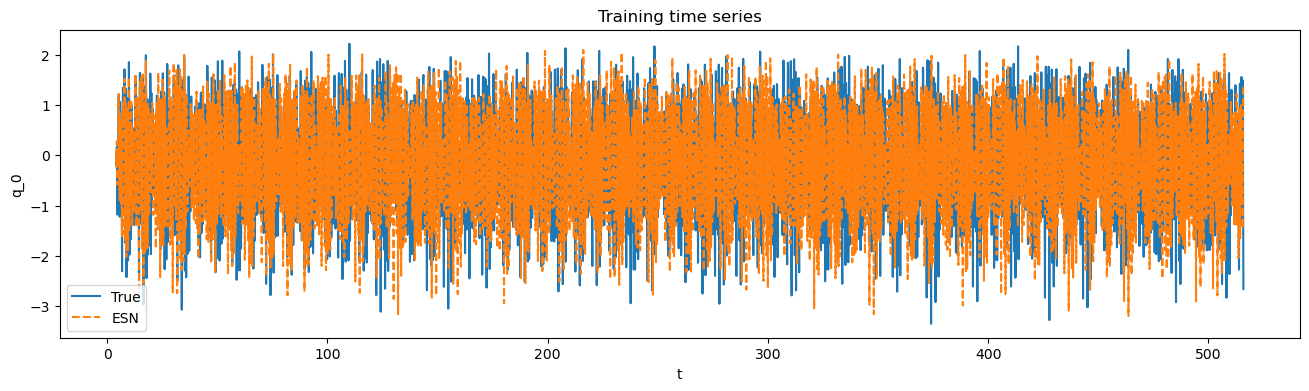

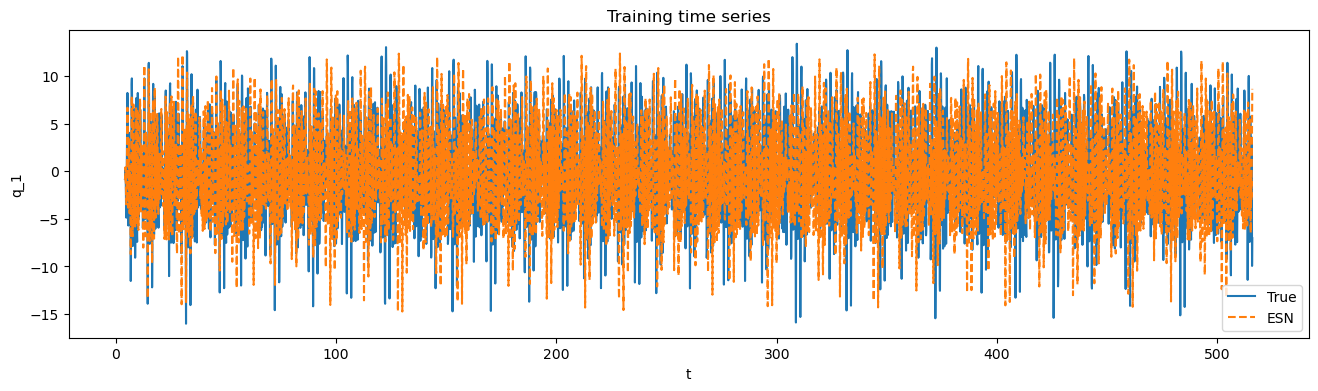

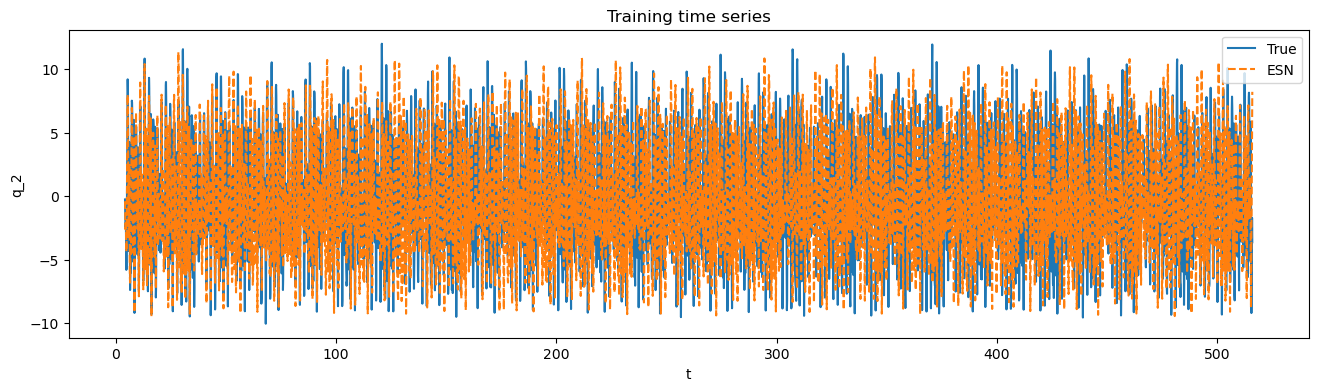

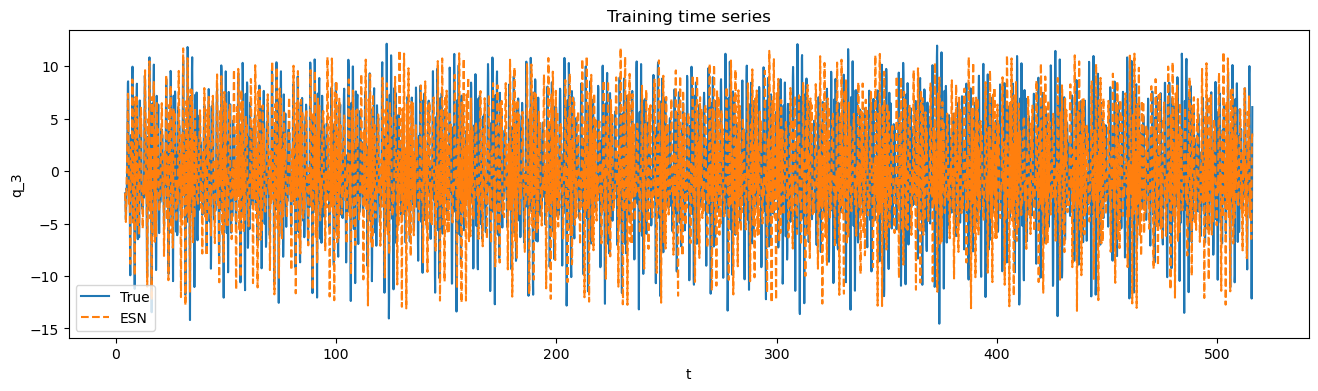

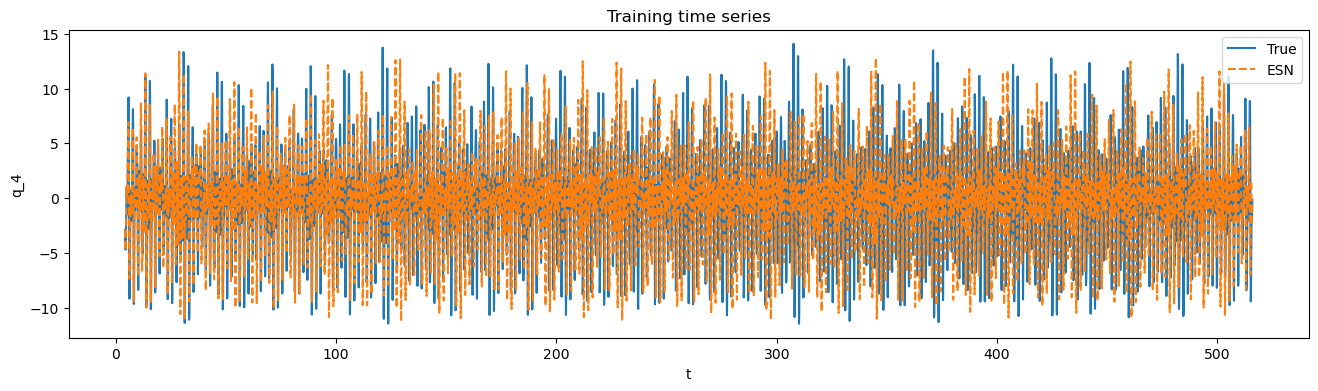

In [73]:
#my_lorenz63.t_lyap
for j in range(np.minimum(dim,5)):
    plt.figure(figsize=(16,4))
    plt.plot(t_train, Y_train[:,j])
    plt.plot(t_train, Y_pred_train[:,j],'--')
    plt.title("Training time series")
    plt.xlabel("t")
    plt.ylabel(f"q_{j}")
    plt.legend(["True", "ESN"])

In [74]:
X_pred_val, Y_pred_val = my_ESN.closed_loop_with_washout(U_washout_val, N_t = N_val-1)
Y_pred_val = Y_pred_val[1:,:]

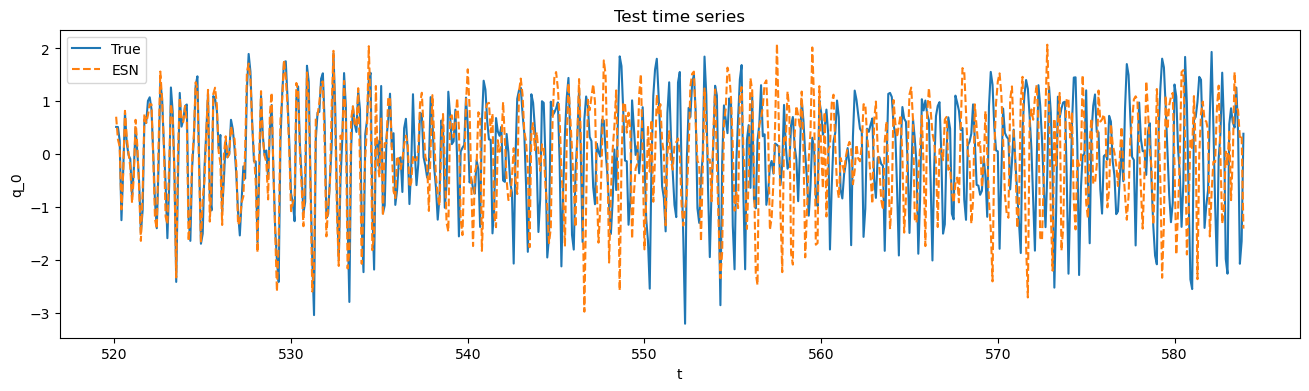

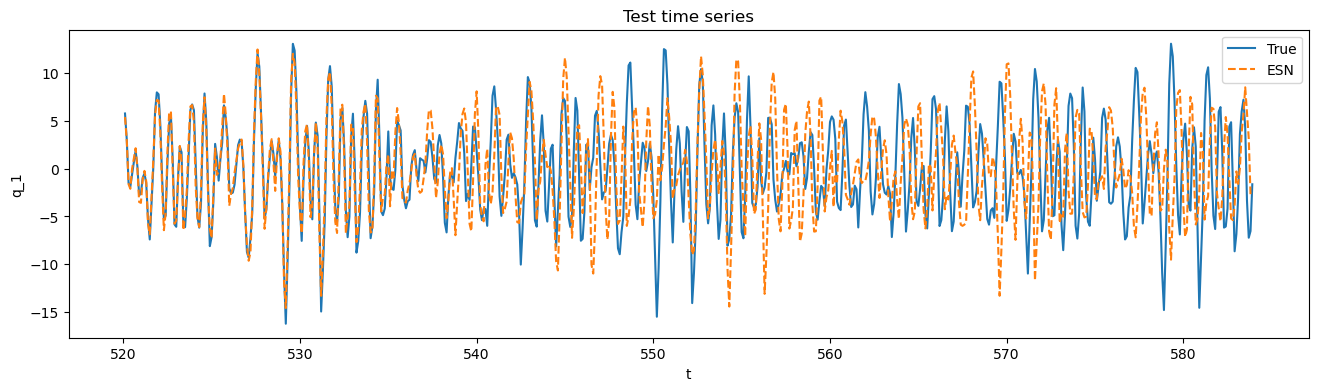

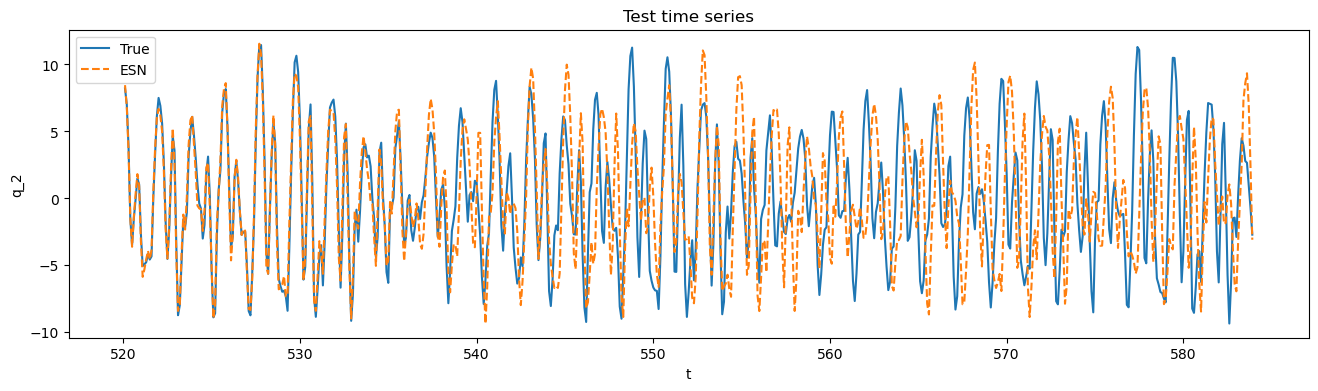

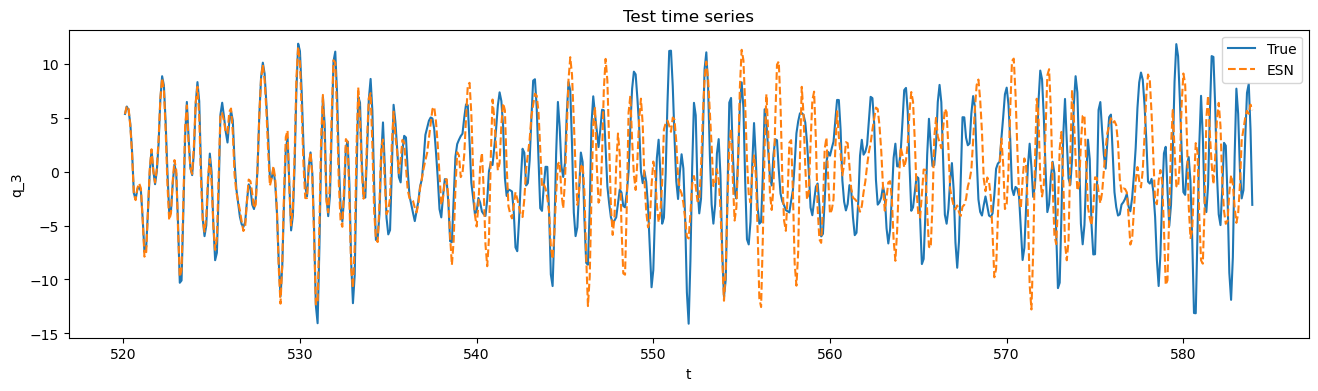

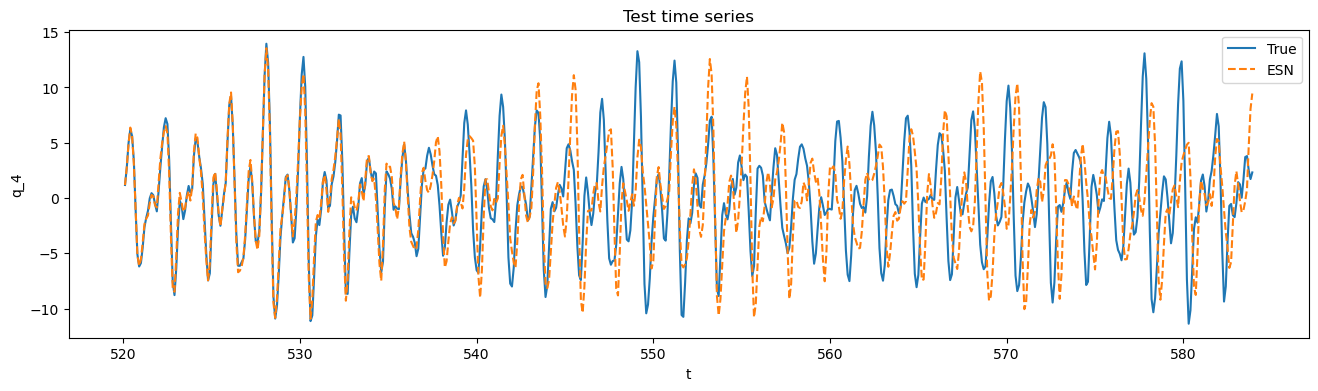

In [75]:
#my_lorenz63.t_lyap
for j in range(np.minimum(dim,5)):
    plt.figure(figsize=(16,4))
    #plt.plot(t_val, Y_val[:,j]-Y_pred_val[:,j])
    plt.plot(t_val, Y_val[:,j])
    plt.plot(t_val, Y_pred_val[:,j],'--')
    plt.title("Test time series")
    plt.xlabel("t")
    plt.ylabel(f"q_{j}")
    plt.legend(["True", "ESN"])

In [ ]:
# calculate error
def L2_error(y, y_pred):
    return np.linalg.norm(y-y_pred, 'fro')
train_error = L2_error(Y_train, Y_pred_train)
val_error = L2_error(Y_val, Y_pred_val)
print("Train error: ", train_error)
print("Validation error: ", val_error)

In [ ]:
from adjoint_esn.validation import validate

#range for hyperparameters (spectral radius and input scaling)
spec_in     = .1    
spec_end    = 1.   
in_scal_in  = np.log10(0.05)
in_scal_end = np.log10(5.)
leak_in     = .1    
leak_end    = 1.   
grid_range = [[spec_in, spec_end], [in_scal_in, in_scal_end]]

# In case we want to start from a grid_search, 
# the first n_grid_x*n_grid_y points are from grid search
n_grid_x = 6 
n_grid_y = 6
#n_grid_z = 4

param_names = ['spectral_radius', 'input_scaling']
param_scales = ['uniform', 'log10']
n_grid = [n_grid_x, n_grid_y]

ESN_dict = {'reservoir_size': 1000, 
            'dimension' : dim, 
            'reservoir_connectivity' : 3,
            'input_normalization': scale, 
            'input_bias' : input_bias}
min_dict = validate(n_grid, grid_range, param_names, param_scales, 
    n_bo = 4, n_initial = 0, n_ensemble = 3, ESN_dict = ESN_dict, U_washout = U_washout_train, 
    U = U_train, Y = Y_train, n_folds = 20, N_init_steps = N_washout, N_fwd_steps = 40, N_washout_steps = N_washout, N_val_steps = N_val)

In [ ]:
# Calculate jacobian of the reservoir states analytically
x_0 = X_pred_train[0,:]
x_1 = X_pred_train[1,:]
my_jac = my_ESN.jac(x_1)
# now compare this jacobian to the numerical one
def closed_loop_step(x_0):
    x_0_augmented = np.hstack((x_0, my_ESN.b_out))
    y_0 = np.dot(x_0_augmented, my_ESN.W_out)
    x_1 = my_ESN.step(x_0, y_0)
    return x_1
h = 1e-5
my_jac_num = np.zeros((my_ESN.N_reservoir,my_ESN.N_reservoir))
dJ_dx_0_num = np.zeros((my_ESN.N_reservoir))
for i in range(my_ESN.N_reservoir):
    x_0_left = x_0.copy()
    x_0_left[i] -= h
    x_0_right = x_0.copy()
    x_0_right[i] += h
    x_1_left = closed_loop_step(x_0_left)
    x_1_right = closed_loop_step(x_0_right)
    J_1_left = np.sum(x_1_left**2)
    J_1_right = np.sum(x_1_right**2)
    dJ_dx_0_num[i] = (J_1_right-J_1_left)/(2*h)
    for j in range(my_ESN.N_reservoir):
        my_jac_num[j,i] = (x_1_right[j]-x_1_left[j])/(2*h)
        
print("Difference of analytical vs numerical Jacobian:",np.where(np.abs(my_jac_num-my_jac.toarray()) > 1e-8))

In [ ]:
# Find the adjoint for one step
dJ_dx_1 = 2*x_1
dx_1_dx_0 = my_ESN.jac(x_1).toarray()
dJ_dx_0 = np.dot(dJ_dx_1,dx_1_dx_0)
v_1 = dJ_dx_1
v_0 = np.dot(dx_1_dx_0.T,v_1)
print("Difference of direct vs adjoint calculation:", np.where(dJ_dx_0 != v_0))
print("Difference of direct vs numerical calculation:",np.where(np.abs(dJ_dx_0_num-dJ_dx_0) > 1e-8))
print("Difference of adjoint vs numerical calculation:",np.where(np.abs(dJ_dx_0_num-v_0) > 1e-8))

In [ ]:
# calculate gradient for a timeseries, direct method
# terminal state objective 
#N = X_pred_train.shape[0]
N = 10
q_prev = np.eye(my_ESN.N_reservoir)
for i in np.arange(1,N):
    q = np.dot(my_ESN.jac(X_pred_train[i,:]).toarray(),q_prev)
    q_prev = q
dJ_dx_0 = np.dot(2*X_pred_train[N-1,:],q)

In [85]:
# calculate gradient for a timeseries, direct method
# time averaged objective
#N = X_pred_train.shape[0]
N = 100
q_prev = np.eye(my_ESN.N_reservoir)
dJ_dx_0 = 2*X_pred_train[0,:]
for i in np.arange(1,N):
    q = np.dot(my_ESN.jac(X_pred_train[i,:]).toarray(),q_prev)
    q_prev = q
    dJ_dx_0 += np.dot(2*X_pred_train[i,:],q)
dJ_dx_0 = (1/N)*dJ_dx_0

In [ ]:
# calculate gradient for a timeseries, adjoint method
# terminal state objective 
v_prev = 2*X_pred_train[N-1,:]
for i in np.arange(N-1,0,-1):
    v = np.dot(my_ESN.jac(X_pred_train[i,:]).toarray().T,v_prev)
    v_prev = v
dJ_dx_0_adj = v

In [86]:
# calculate gradient for a timeseries, adjoint method
# time averaged objective
v_prev = 2*X_pred_train[N-1,:]
for i in np.arange(N-1,0,-1):
    v = np.dot(my_ESN.jac(X_pred_train[i,:]).toarray().T,v_prev)+2*X_pred_train[i-1,:].T
    v_prev = v
dJ_dx_0_adj = (1/N)*v

In [ ]:
# calculate gradient for a timeseries, numerical method
# terminal state objective 
x_0 = X_pred_train[0,:]
h = 1e-5
dJ_dx_0_num = np.zeros((my_ESN.N_reservoir))
for i in range(my_ESN.N_reservoir):
    x_0_left = x_0.copy()
    x_0_left[i] -= h
    x_0_right = x_0.copy()
    x_0_right[i] += h
    X_left, _ = my_ESN.closed_loop(x_0_left, N-1)
    X_right, _ =  my_ESN.closed_loop(x_0_right, N-1)
    J_left = np.sum(X_left[-1,:]**2)
    J_right = np.sum(X_right[-1,:]**2)
    dJ_dx_0_num[i] = (J_right-J_left)/(2*h)

In [87]:
# calculate gradient for a timeseries, numerical method
# time averaged objective
x_0 = X_pred_train[0,:]
h = 1e-5
dJ_dx_0_num = np.zeros((my_ESN.N_reservoir))
for i in range(my_ESN.N_reservoir):
    x_0_left = x_0.copy()
    x_0_left[i] -= h
    x_0_right = x_0.copy()
    x_0_right[i] += h
    X_left, _ = my_ESN.closed_loop(x_0_left, N-1)
    X_right, _ =  my_ESN.closed_loop(x_0_right, N-1)
    J_left = np.mean(np.sum(X_left**2, axis = 1))
    J_right = np.mean(np.sum(X_right**2, axis = 1))
    dJ_dx_0_num[i] = (J_right-J_left)/(2*h)

In [88]:
print("Difference of direct vs adjoint calculation:", np.where(np.abs(dJ_dx_0 - dJ_dx_0_adj) > 1e-12))
print("Difference of direct vs numerical calculation:", np.where(np.abs(dJ_dx_0 - dJ_dx_0_num) > 1e-5))

Difference of direct vs adjoint calculation: (array([], dtype=int64),)
Difference of direct vs numerical calculation: (array([], dtype=int64),)


In [89]:
# Taylor test
epsilon_list = [1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]
J_0 = np.mean(np.sum(X_pred_train[:N,:]**2, axis = 1))
taylor = np.zeros((len(epsilon_list),my_ESN.N_reservoir))
for epsilon_idx, epsilon in enumerate(epsilon_list):
    for i in range(my_ESN.N_reservoir):
        x_0_right = x_0.copy()
        x_0_right[i] += epsilon
        X_right, _ =  my_ESN.closed_loop(x_0_right, N-1)
        J_1 = np.mean(np.sum(X_right**2, axis = 1))
        taylor[epsilon_idx, i] = J_1-J_0-epsilon*dJ_dx_0_adj[i]

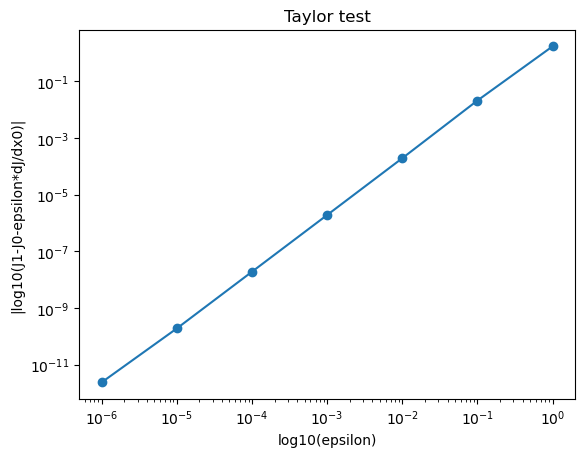

In [90]:
plt.plot(epsilon_list,np.abs(taylor[:,0]),'o-')
plt.xlabel("log10(epsilon)")
plt.ylabel("|log10(J1-J0-epsilon*dJ/dx0)|")
plt.xscale("log")
plt.yscale("log")
plt.title("Taylor test")
plt.show()